# Activations

We extract hidden layer's activations from models.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# Load pytorch model with torch
model_path = "../data/Frozen_MiniAbsolut_ML/1_vs_1/1NSN__vs__3VRL/swa_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))
model_nswa = torch.load(
    "../data/Frozen_MiniAbsolut_ML/1_vs_1/1NSN__vs__3VRL/trained_model/data/model.pth",
    map_location=torch.device('cpu'),
    )

# Load test data
test_data_path = "../data/Frozen_MiniAbsolut_ML/1_vs_1/1NSN__vs__3VRL/49d0d73a_test_dataset.tsv"
df = pd.read_csv(test_data_path, sep="\t")
df

,Slide,binds_a_pos_ag,Slide_onehot,X,y
0,AALITTPLYFD,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
1,AANWDLLFDYW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
2,AANWELFFDYW,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
3,AAVVAVPMDYW,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
4,ACGLRRGFAYW,1,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
...,...,...,...,...,...
9995,YYTIHGGFAYW,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
9996,YYTLFYAMDYW,0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
9997,YYTLTPGFAYW,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
9998,YYYGSLPMDYW,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1


In [3]:
def get_activations_on_slide(slide: str, model: nn.Module):
    x = torch.tensor(preprocessing.onehot_encode(slide)).reshape((1, -1))
    x = x.float()
    x = model.module.flatten(x)
    x = model.module.linear_1(x)
    x = model.module.activation(x)
    return x

def get_logits_on_slide(slide: str, model: nn.Module):
    x = get_activations_on_slide(slide, model)
    x = model.module.linear_2(x)
    return x

def get_linear_2_weights(model: nn.Module):
    return model.module.linear_2.weight


w2 = get_linear_2_weights(model)
print(w2)
x = get_activations_on_slide(df["Slide"].iloc[0], model)
x

Parameter containing:
tensor([[ 2.9326,  4.2683, -1.4028,  3.2538, -1.7029, -1.3923,  1.8893,  3.4053,
          3.1166,  3.1151]], requires_grad=True)


tensor([[2.1475, 0.0000, 3.4832, 2.3049, 0.0000, 2.1901, 1.0379, 2.6781, 3.2862,
         3.4275]], grad_fn=<ReluBackward0>)

In [4]:
records = []
for i, row in df.iterrows():
    slide = row["Slide"]
    
    activations = get_activations_on_slide(slide, model)
    logits = get_logits_on_slide(slide, model)

    record = {
        "Slide": slide,
        "logits": float(logits),
        **{f"neuron_{j}": float(a) for j,a in enumerate(activations.tolist()[0])},
    }
    records.append(record)

df_comp = pd.DataFrame.from_records(records)
df = pd.read_csv(test_data_path, sep="\t")
df = pd.merge(df, df_comp, on="Slide")
df = df.sort_values("logits", ascending=False)
df = df.reset_index(drop=True)
print(df.shape)
# df

(10000, 16)


Text(0.5, 0, 'Slide ~ logit')

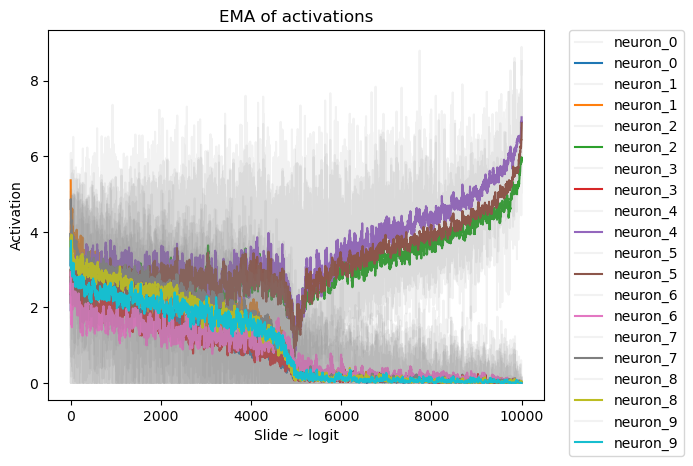

In [5]:
for i in range(10):

    # Compute EMA
    # Plot column without label in legend
    df[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
    ema = df[f"neuron_{i}"].ewm(span=30).mean()
    ema.plot()

# Place legend out of grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("EMA of activations")
plt.ylabel("Activation")
plt.xlabel("Slide ~ logit")

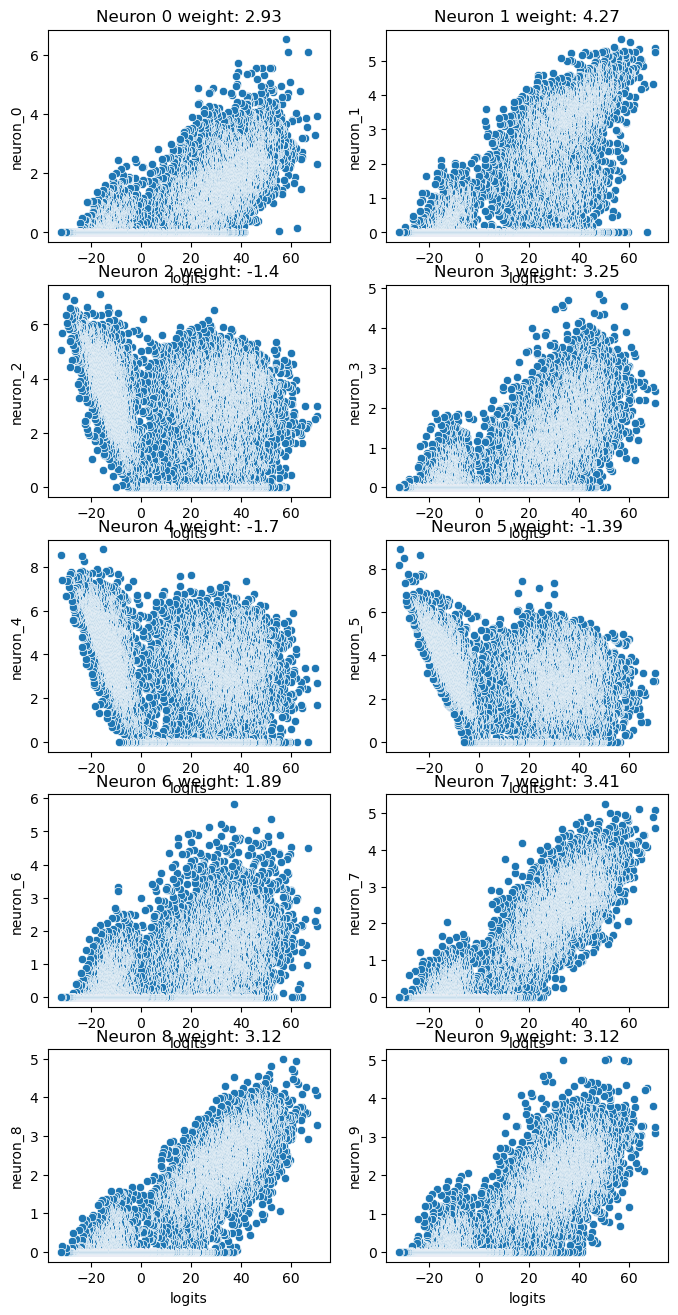

In [6]:
# Plot for each neuron activation vs logits in 
# a seaborn multiplot. Add w2 weights to title.
fig, axes = plt.subplots(5, 2, figsize=(8, 16))
for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x="logits", y=f"neuron_{i}", data=df, ax=ax)
    ax.set_title(f"Neuron {i} weight: {round(float(w2[0][i]), 2)}")

In [7]:
w1 = model.module.linear_1.weight
pd.DataFrame(w1[0].reshape((11, 20)).detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.075590,0.017990,1.624395,0.503876,-0.461129,1.334347,1.069464,-0.514884,0.317487,-0.577830,-0.244406,0.635118,0.808988,0.098029,0.660034,0.793333,1.247787,-0.086745,-0.598702,-0.051459
1,-0.155649,-0.656734,-0.129413,-0.114078,-0.850263,-0.048890,-0.007992,-0.037175,0.264228,-0.091994,-0.170204,0.175073,0.321956,1.131084,0.446588,0.544460,0.295155,-0.258164,-0.190145,0.040407
2,0.611494,-0.954129,0.756964,0.084318,-0.773329,0.374458,0.369671,-0.631407,0.422475,0.096328,-0.361014,0.542022,-0.036158,0.067208,0.003591,0.266820,0.106739,-0.987806,-1.142182,-0.530567
3,-0.204197,-0.477677,0.034254,0.705258,0.030163,0.331604,0.471515,-0.272673,1.167391,-0.007391,-0.231064,0.453817,0.244070,1.136327,0.710000,0.560631,-0.046910,0.059274,-0.882575,-0.201019
4,0.320613,-0.623454,0.923157,0.665580,-0.787873,0.122095,0.270062,-1.265017,0.570541,-1.375939,-0.989229,-0.102820,0.466024,0.348137,0.588982,0.234570,-0.089681,-0.225139,-0.630753,-0.596576
5,0.069980,0.189911,1.245592,0.809476,-0.614991,0.625897,0.529295,-0.178862,0.473881,-0.859803,0.347534,0.800108,0.932775,0.543756,-0.115175,0.679668,0.617346,-0.137885,0.181152,-0.044551
6,0.082260,-0.179278,0.294300,0.891827,-1.551316,0.558299,0.269914,-0.271610,1.035810,-1.546419,-0.733389,0.466357,0.597441,0.066381,0.398413,1.396296,0.286739,-0.714268,-0.570998,-0.005433
7,-0.045690,0.524767,-0.069749,0.855356,-0.046721,-0.200723,0.166395,-0.044349,-0.077630,-0.438992,-0.350317,0.483170,0.803832,0.671416,-0.097289,0.358064,-0.629625,0.229602,0.902462,0.415317
8,0.289671,-0.556468,0.344288,-0.174745,-0.044490,-0.071630,-0.046899,-0.927683,0.614075,-1.030057,-0.796570,-0.460447,0.157628,0.271746,0.332450,-0.094922,0.510806,-0.540572,-0.530070,0.730984
9,0.714423,0.368805,0.378264,0.154097,-0.020156,0.208269,0.035904,-0.226633,-0.007403,-0.947319,-0.269927,-0.276087,-0.190005,0.114893,-0.168296,0.768500,0.516430,-0.147042,-0.370262,0.271590


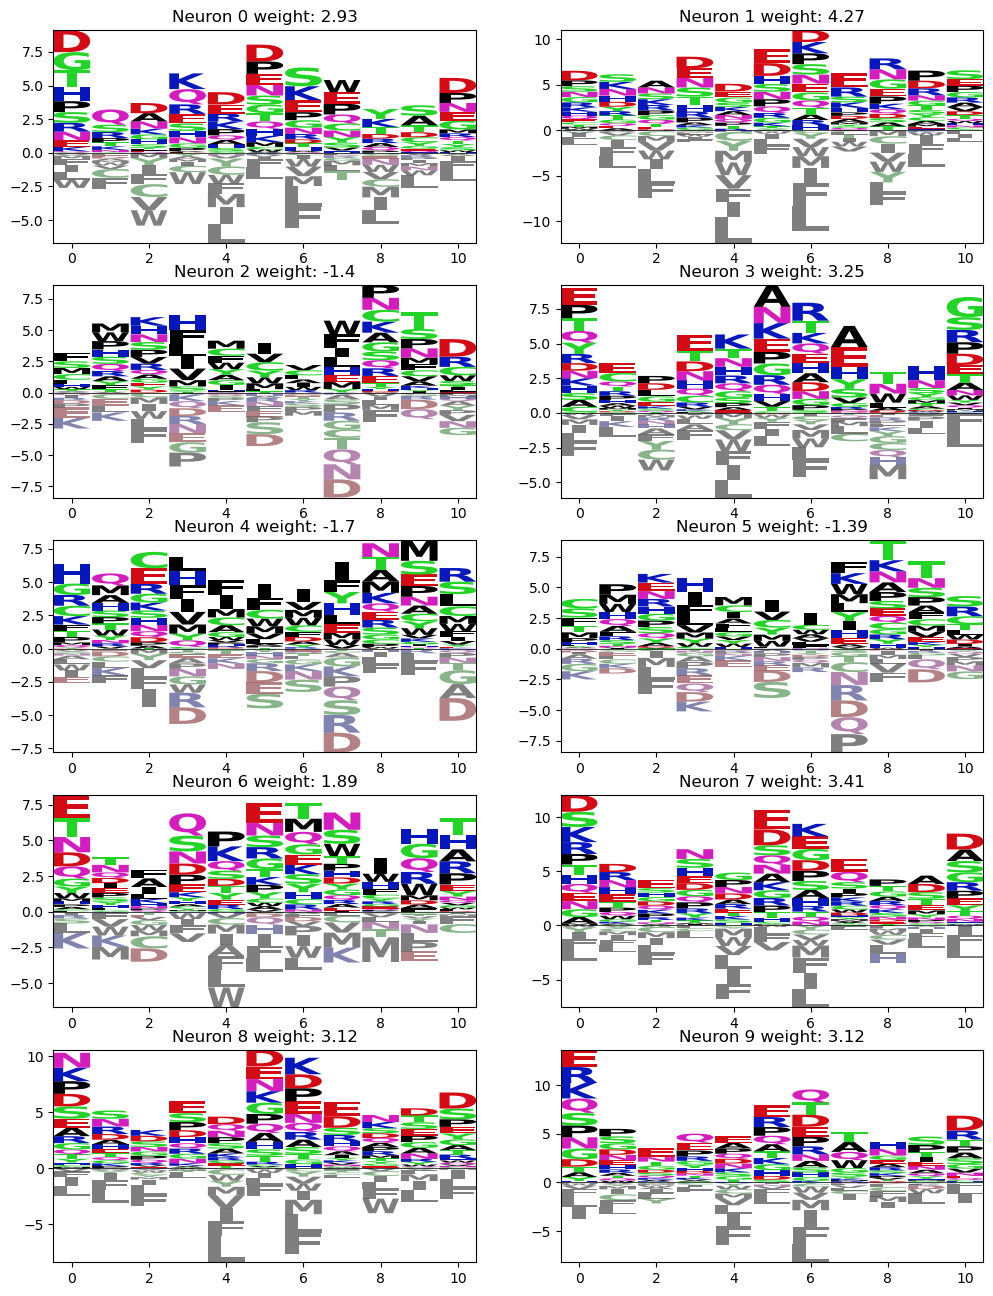

In [8]:
# Plot for each neuron motif logo with logomaker
# based on the weights in w1.
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    w1 = model.module.linear_1.weight
    logo = visualisations.plot_logo(
        pd.DataFrame(w1[i].reshape((11, 20)).detach().numpy(), columns=config.AMINOACID_ALPHABET),
        ax=ax)
    ax.set_title(f"Neuron {i} weight: {round(float(w2[0][i]), 2)}")

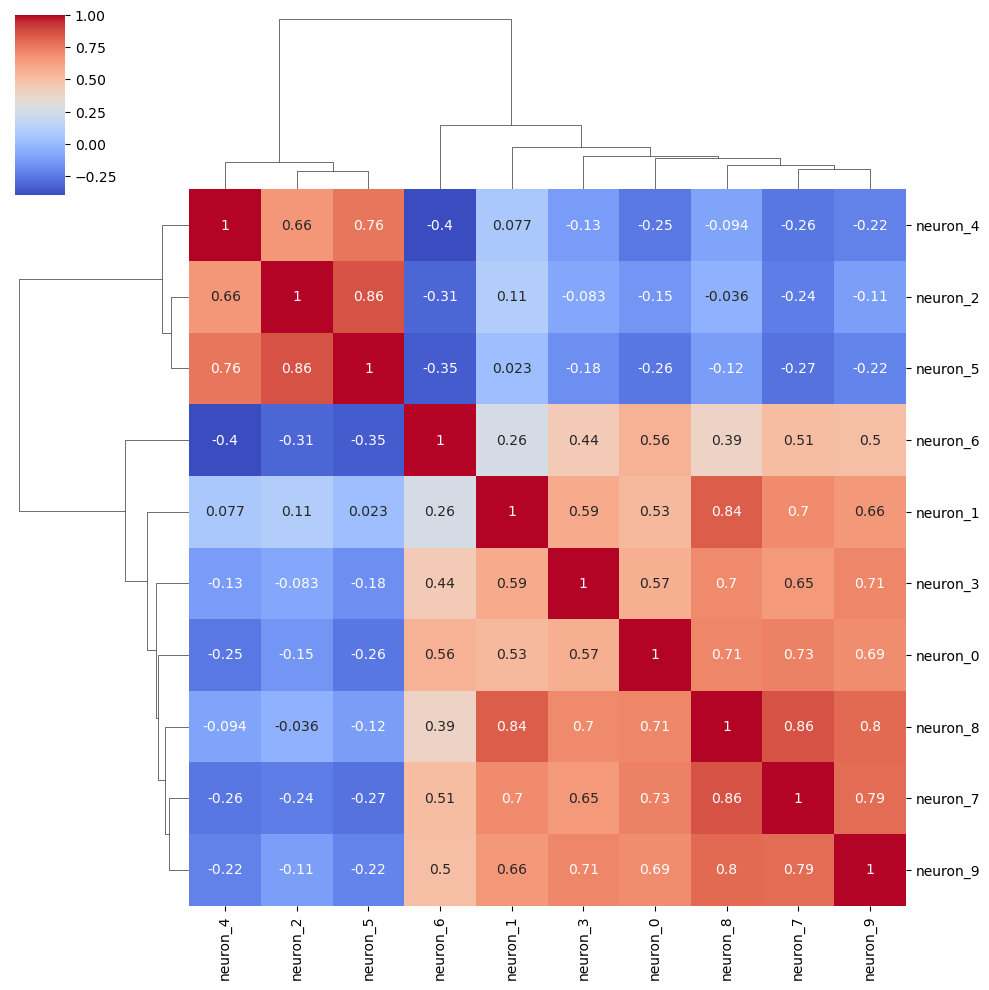

In [9]:
# Correlation among neuron activations
corr = df[[f"neuron_{i}" for i in range(10)]].corr()
sns.clustermap(corr, annot=True, cmap="coolwarm")

In [10]:
df_x = pd.read_csv(
    "../data/xstreme/1vs1/1NSN_vs_3VRL/xstreme.tsv", 
    sep="\t",
    skipfooter=4,
    )
df_x

/tmp/ipykernel_559029/4051951651.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_x = pd.read_csv(


,RANK,SEED_MOTIF,CLUSTER,SOURCE,ID,ALT_ID,CONSENSUS,WIDTH,SITES,SEA_PVALUE,EVALUE,EVALUE_ACC,SIM_SOURCE,SIM_MOTIF,MOTIF_URL
0,1,1,1,STREME,2-LDYDLDYF,STREME-2,LDYDLDYF,8,997,0.000000e+00,1.790000e-29,1,STREME,2-LDYDLDYF,
1,2,1,2,STREME,1-GGGFAY,STREME-1,GGGFAY,6,2358,0.000000e+00,9.230000e-62,1,STREME,1-GGGFAY,
2,3,1,3,STREME,6-YDYDL,STREME-6,YDYDL,5,176,8.520000e-125,4.960000e-02,1,STREME,6-YDYDL,
3,4,1,4,STREME,8-LRYAWFA,STREME-8,LRYAWFA,7,52,1.720000e-100,1.120000e+00,1,STREME,8-LRYAWFA,
4,5,1,5,STREME,3-LLLRLYWYFD,STREME-3,LLLRLYWYFD,10,341,1.070000e-97,3.420000e-07,1,STREME,3-LLLRLYWYFD,
5,6,1,6,STREME,9-YDGFA,STREME-9,YDGFA,5,49,2.970000e-89,2.810000e+00,1,STREME,9-YDGFA,
6,7,1,7,STREME,7-CARLGGGLAY,STREME-7,CARLGGGLAY,10,60,1.030000e-75,5.590000e-01,1,STREME,7-CARLGGGLAY,
7,8,1,8,STREME,5-RRERLRLFAY,STREME-5,RRERLRLFAY,10,93,9.190000e-52,1.700000e-02,1,STREME,5-RRERLRLFAY,
8,9,1,9,STREME,4-ARVVGLRMDY,STREME-4,ARVVGLRMDY,10,101,1.150000e-33,2.060000e-03,1,STREME,4-ARVVGLRMDY,


In [11]:
df_x = pd.read_csv(
    "../data/xstreme/1vs1/3VRL_vs_1NSN/xstreme.tsv", 
    sep="\t",
    skipfooter=4,
    )
df_x

/tmp/ipykernel_559029/3525085957.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_x = pd.read_csv(


,RANK,SEED_MOTIF,CLUSTER,SOURCE,ID,ALT_ID,CONSENSUS,WIDTH,SITES,SEA_PVALUE,EVALUE,EVALUE_ACC,SIM_SOURCE,SIM_MOTIF,MOTIF_URL
0,1,1,1,STREME,1-LLDYF,STREME-1,LLDYF,5,4584,0.000000e+00,1.870000e-121,1,STREME,1-LLDYF,
1,2,1,2,STREME,2-CARG,STREME-2,CARG,4,1727,1.300000e-166,4.700000e-19,1,STREME,2-CARG,
2,3,0,2,STREME,6-CARLIL,STREME-6,CARLIL,6,40,2.330000e-155,1.310000e+00,1,STREME,6-CARLIL,
3,4,0,2,STREME,4-CARLRW,STREME-4,CARLRW,6,63,1.070000e-79,5.350000e-02,1,STREME,4-CARLRW,
4,5,0,2,STREME,5-ARQL,STREME-5,ARQL,4,123,4.990000e-68,2.240000e-01,1,STREME,5-ARQL,
5,6,0,2,STREME,3-ARRW,STREME-3,ARRW,4,130,7.310000e-48,4.180000e-03,1,STREME,3-ARRW,
6,7,0,2,STREME,7-ARBGGW,STREME-7,ARBGGW,6,31,6.310000e-06,3.500000e+00,1,STREME,7-ARBGGW,


In [70]:
# Fetch XSTREME results

import re
from dataclasses import dataclass
from typing import List, Optional, Union


@dataclass
class XStremeMotif:
    id: str
    seq: str
    pwm: np.ndarray
    start: int
    stop: int
    fimo_tsv_path: Optional[Path] = None

    def __post_init__(self):
        self.pwm = np.array(self.pwm)

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(12, 1))
        visualisations.plot_logo(
            pd.DataFrame(self.pwm, columns=config.AMINOACID_ALPHABET),
            ax=ax,
            allow_other_shape=True
        )
        ax.set_title(self.seq)
        return ax    


@dataclass
class XStremeResults:
    res_path: Union[Path, str]

    def __post_init__(self):
        self.res_path = Path(self.res_path)
        self.xstreme_tsv_path = self.res_path / "xstreme.tsv"
        self.xstreme_txt_path = self.res_path / "xstreme.txt"

        # Load tsv data
        self.df_xstreme = pd.read_csv(
            self.xstreme_tsv_path, 
            sep="\t",
            skipfooter=4,
            engine="python",
        )

        self.motifs: List[XStremeMotif] = self.extract_motifs()


    def extract_motifs(self):

        with open(self.xstreme_txt_path, "r") as f:
            txt = f.read()

        ### Regex pattern to extract motif
        # Regex pattern for any digit: \d
        # Regex pattern for any letter some number of times: \w+
        # Regex pattern for anything anytime until \n:  
        # Regex pattern for a row of numbers: \d+\.?\d*
        # Explaination for last pattern: 
        #   - \d+ matches one or more digits
        #   - \.? matches a dot zero or one times
        #   - \d* matches zero or more digits
        # Regex pattern for tab: \t
        pattern = (
            r"MOTIF (\d+-\w+) STREME-\d\n\n"
            r"letter-probability matrix:.*\n"
            r"(((\s\s\d+\.?\d*\t){20}\n){1,11})"
        )

        # Count number of occurences
        regex_found = re.findall(pattern, txt)
        motifs: List[XStremeMotif] = []
        for i, regex_groups in enumerate(regex_found):
            
            # Extract motif name and matrix from regex results
            motif_name, motif_matrix_as_str = regex_groups[0], regex_groups[1]
            motif_id = motif_name.split("-")[0]
            motif_seq = motif_name.split("-")[1]
        
            # Extract floats from motif matrix
            floats: List[str] = re.findall(r"\d+\.?\d*", motif_matrix_as_str)
            floats = [float(f) for f in floats]
            pwm = np.array(floats).reshape(-1, 20)

            # Find most frequent start and stop positions
            fimo_tsv_path = self.res_path / f"fimo_out_{i+1}/fimo.tsv"
            df_fimo = pd.read_csv(
                fimo_tsv_path,
                sep='\t',
                skipfooter=4,
                engine="python",
            )
            val_counts = df_fimo[["start", "stop"]].value_counts()
            top_start, top_stop = val_counts.index[0]
        
            motif = XStremeMotif(
                id=motif_id,
                seq=motif_seq,
                pwm=pwm,
                start=top_start,
                stop=top_stop,
                fimo_tsv_path=fimo_tsv_path,
            )
            motifs.append(motif)
        
        return motifs
        

In [13]:
input_dir = "../data/xstreme/1vs1/1NSN_vs_3VRL/"
xstreme_results = XStremeResults(input_dir)
motifs = xstreme_results.motifs

print(len(motifs))

9


<AxesSubplot: title={'center': 'LDYDLDYF'}>

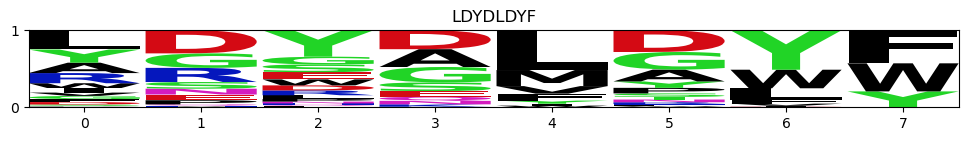

In [14]:
motifs[0].plot()

In [15]:
motifs[0].id

'2'

Add motifs to slides.

In [71]:
xstreme_results_forw = XStremeResults("../data/xstreme/1vs1/1NSN_vs_3VRL/")  # 2-LDYDLDYF 1-GGGFAY
xstreme_results_backw = XStremeResults("../data/xstreme/1vs1/3VRL_vs_1NSN/")  # 1-LLDYF 2-CARG


df_1nsn = pd.read_csv(
    "../data/MiniAbsolut/1NSN/high_test_5000.tsv",
    sep='\t',
)

df_3vrl = pd.read_csv(
    "../data/MiniAbsolut/3VRL/high_test_5000.tsv",
    sep='\t',
)

In [72]:
motif_2_1nsn = xstreme_results_forw.motifs[0]
df_fimo = pd.read_csv(
    motif_2_1nsn.fimo_tsv_path,
    sep='\t',
    skipfooter=4,
    engine="python",
)
df_fimo["index"] = df_fimo["sequence_name"].str.split("Slide").str[1].astype(int)
df_fimo.set_index("index", inplace=True)

df_with_motif = pd.merge(df_1nsn, df_fimo, left_index=True, right_index=True, how="left")
df_with_motif = df_with_motif.loc[~df_with_motif["motif_id"].isna()]

In [73]:
df_with_motif

,Unnamed: 0,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,6103,2117197_00a,CARHELPWFAYW,True,CARHELPWFAY,-90.92,137504-LSUSURSSSD,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide0,2.0,9.0,+,12.4921,0.000028,0.000562,ARHELPWF
2,29790,5239398_03a,CARVLQFREAMDYW,True,VLQFREAMDYW,-94.07,145763-BSSRDLDRDL,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide2,4.0,11.0,+,14.9683,0.000002,0.000150,FREAMDYW
5,195,4868272_00a,CAGGDLAWFAYW,True,CAGGDLAWFAY,-91.39,137504-LSUSURSSSD,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide5,2.0,9.0,+,11.6984,0.000054,0.000758,AGGDLAWF
6,25375,2550235_04a,CARGLADYDVSWFAYW,True,LADYDVSWFAY,-94.77,137504-LSUSURSSSD,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide6,2.0,9.0,+,13.3175,0.000013,0.000376,ADYDVSWF
8,19363,6020872_03a,CAILVNWDEGIAYW,True,LVNWDEGIAYW,-93.91,137504-LLURULURSS,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide8,4.0,11.0,+,12.2063,0.000036,0.000633,WDEGIAYW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972,21300,5108325_01a,CAFQLGREMDYW,True,AFQLGREMDYW,-90.01,145763-BSSRDLDRDL,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide4972,4.0,11.0,+,15.3016,0.000001,0.000129,LGREMDYW
4975,22327,2006055_00a,CTAYDYSFAYW,True,CTAYDYSFAYW,-90.46,137504-LLURULURSS,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide4975,4.0,11.0,+,11.8095,0.000050,0.000723,YDYSFAYW
4987,6110,2669977_04a,CAKNLRNWDWAMDYW,True,LRNWDWAMDYW,-91.48,137504-LLURULURSS,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide4987,4.0,11.0,+,13.7778,0.000008,0.000307,WDWAMDYW
4992,22146,2553804_04a,CARWLYDYDVSYYYAMDYW,True,LYDYDVSYYYA,-92.18,137504-LSUSURSSSD,mascotte,1NSN,2-LDYDLDYF,STREME-2,Slide4992,2.0,9.0,+,12.5714,0.000027,0.000548,YDYDVSYY


Extract attributions and compare to motifs.

In [96]:
df_test = df
attributors = [
    ml.Attributor(
        model_nswa,  
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=input,
    )
]
df_a = ml.compute_and_collect_model_predictions_and_attributions(
    df_test, 
    model_nswa, 
    attributors,
    N=100
)

In [97]:
df_para = utils.load_paratopes()
df_sel = ml.get_df_sel(
    attributors[0].name, 
    df_a, 
    df_para, 
    ag_pos="1NSN", 
    ag_neg="3VRL",
)

In [98]:
df_sel

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,VRDDQVAWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",102.214401,1.000000e+00,1,1,True,"[[tensor(-1.7461, grad_fn=<UnbindBackward0>), ...",shuffle,1NSN,VRDDQVAWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,V4R2D1D2--V4A2W3F3A2Y2*
1,CTGFQNSLDYW,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",93.186516,1.000000e+00,1,1,True,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso...",shuffle,1NSN,CTGFQNSLDYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,C4T2G1F3--N2--L4D2Y3W3*
2,CTTLGEGFHYW,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",89.634834,1.000000e+00,1,1,True,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso...",shuffle,1NSN,CTTLGEGFHYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,C4T2T1L3--E2--F4H2Y3W3*
3,VVDLEDAMDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",84.392921,1.000000e+00,1,1,True,"[[tensor(-1.6587, grad_fn=<UnbindBackward0>), ...",shuffle,1NSN,VVDLEDAMDYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,V3V3D2L4--D2--M3D1Y2W4*
4,VRALTGKFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",83.518028,1.000000e+00,1,1,True,"[[tensor(-4.2432, grad_fn=<UnbindBackward0>), ...",shuffle,1NSN,VRALTGKFAYW,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,V4R2A1L3--G2--F4A2Y3W3*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CARHEVLLLSF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-36.651184,1.209464e-16,0,0,True,"[[tensor(-0.1526, grad_fn=<UnbindBackward0>), ...",shuffle,3VRL,CARHEVLLLSF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--H2E1V3L3L3L1S2F4*
96,CARLLLRYGGW,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-36.695789,1.156701e-16,0,0,True,"[[tensor(-0.4409, grad_fn=<UnbindBackward0>), ...",shuffle,3VRL,CARLLLRYGGW,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C4A2R1L3L3L3R1Y2--G1W2*
97,CARIDLLWAYW,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-40.162003,3.612966e-18,0,0,True,"[[tensor(-0.9535, grad_fn=<UnbindBackward0>), ...",shuffle,3VRL,CARIDLLWAYW,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--I2D1L3L3W3A1Y2W4*
98,CARFRWLLQEF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-40.177139,3.558690e-18,0,0,True,"[[tensor(-0.6541, grad_fn=<UnbindBackward0>), ...",shuffle,3VRL,CARFRWLLQEF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--F2R1W3L3L3Q1E2F4*


In [99]:
df_sel_with_motif = pd.merge(
    df_sel,
    df_with_motif,
    left_on="slide",
    right_on="Slide",
    how="inner",
)

In [100]:
df_sel_with_motif

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,Antigen_x,...,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,GLSGSSLYYFD,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",51.074615,1.0,1,1,True,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso...",shuffle,1NSN,...,2-LDYDLDYF,STREME-2,Slide2634,3.0,10.0,+,11.2698,0.000074,0.000882,SGSSLYYF


In [102]:
attr = df_sel_with_motif["attributions"][0].detach().numpy().reshape((-1, 20))
attr_trim = attr[-8:,]
pwm = motif_2_1nsn.pwm
pwm.shape

(8, 20)

<AxesSubplot: title={'center': 'LDYDLDYF'}>

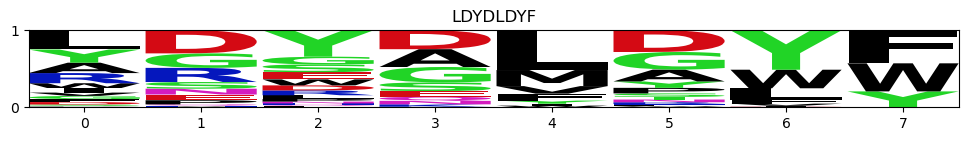

In [103]:
motif_2_1nsn.plot()

In [104]:
from scipy.stats import rankdata

ranks_attr = rankdata(-attr_trim, axis=1, method="ordinal")
ranks_pwm = rankdata(-pwm, axis=1, method="ordinal")

In [105]:
ranks_attr

array([[ 3,  4,  5,  6,  7,  1,  8,  9, 10,  2, 11, 12, 13, 14, 15, 20,
        16, 17, 18, 19],
       [ 5,  6, 20,  7,  3,  8,  9, 10, 11,  1, 12, 13, 14, 15, 16,  2,
        17, 18, 19,  4],
       [ 4,  5,  6,  7,  3, 20,  8,  9, 10,  2, 11, 12, 13, 14, 15,  1,
        16, 17, 18, 19],
       [ 3,  4,  5,  6,  1, 18,  7,  8,  9, 20, 10, 11, 12, 13, 14, 19,
        15, 16, 17,  2],
       [ 3,  4, 20,  5,  6, 18,  7,  8,  9,  2, 10, 11, 12, 13, 14, 19,
        15, 16, 17,  1],
       [ 3,  4, 20,  5,  6, 19,  7,  8,  9,  1, 10, 11, 12, 13, 14, 18,
        15, 16, 17,  2],
       [ 2,  3,  4,  5, 20, 18,  6,  7,  8,  1,  9, 10, 11, 12, 13, 19,
        14, 15, 16, 17],
       [ 4,  5,  1,  6,  2, 19,  7,  8,  9,  3, 10, 11, 12, 13, 14, 18,
        15, 16, 17, 20]])

In [106]:
ranks_pwm

array([[ 3, 16, 10, 14,  9,  8, 12,  6, 19,  1, 18, 15, 13, 20,  4, 11,
        17,  7,  5,  2],
       [10, 15,  1,  6, 13,  2,  9, 17, 20, 11, 19,  5,  7,  8,  3,  4,
        18, 16, 14, 12],
       [16, 17,  6,  4, 13,  2, 11, 19, 20,  8, 15, 10,  9, 12,  7,  3,
        14, 18,  5,  1],
       [ 2, 15,  1,  5, 13,  3, 20, 16,  8, 11, 19,  7, 17,  6,  9,  4,
        18, 10, 14, 12],
       [ 9, 11, 12, 16,  4,  8, 18,  6, 19,  1,  2, 17, 14, 20, 10, 13,
        15,  3,  7,  5],
       [ 3, 16,  1, 13, 15,  2, 10, 18, 14, 11, 19,  8,  5, 20,  9,  6,
         7, 17, 12,  4],
       [10,  9,  7, 15,  4, 11, 18,  6, 19,  3, 16, 17, 13, 20,  8, 12,
        14,  5,  2,  1],
       [ 5,  7,  9, 15,  1,  8, 18, 11, 19,  4, 16, 17, 13, 20,  6, 12,
        14, 10,  2,  3]])

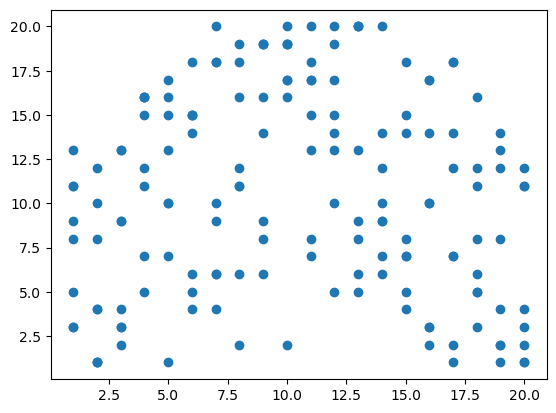

In [107]:
aa_attr_ranks = []
aa_pwm_ranks = []
for i in range(8):
    for j in range(20):
        rank_attr = ranks_attr[i, j]
        aa_attr_ranks.append(rank_attr)
        rank_pwm = ranks_pwm[i, j]
        aa_pwm_ranks.append(rank_pwm)

plt.plot(aa_attr_ranks, aa_pwm_ranks, "o")